In [151]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [152]:
fast = 10
mid = 19
slow = 30

In [153]:
def create_strat_data(yf_data, fast, mid, slow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['FastSMA'] = data['Close'].rolling(window=fast).mean()
    data['MidSMA'] = data['Close'].rolling(window=mid).mean()
    data['SlowSMA'] = data['Close'].rolling(window=slow).mean()
    
    data['Strategy'] = np.where((data['FastSMA'] > data['MidSMA']) & (data['MidSMA'] > data['SlowSMA']), 1, 0)    
    data['Strategy'] = data['Strategy'].shift(1)
    
    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

In [154]:
yf_tsla_data = yf.download('TSLA', period='max', interval='1d') 
TSLA_data = create_strat_data(yf_tsla_data, fast, mid, slow)

[*********************100%***********************]  1 of 1 completed


In [155]:
plot_data = TSLA_data.dropna()
plot_data

Price,Close,High,Low,Open,Volume,FastSMA,MidSMA,SlowSMA,Strategy,Strategy_Returns,Asset_Returns
Date,,,,,,,,,,,
2010-08-10,1.268667,1.310000,1.254667,1.310000,19219500,1.358733,1.370386,1.336089,0.0,0.000000,-0.203432
2010-08-11,1.193333,1.258667,1.190000,1.246000,11964000,1.339933,1.363403,1.322778,0.0,0.000000,-0.250733
2010-08-12,1.173333,1.193333,1.159333,1.186667,10365000,1.321600,1.352737,1.308933,0.0,0.000000,-0.263290
2010-08-13,1.221333,1.230000,1.177333,1.212000,9510000,1.310800,1.340140,1.300844,0.0,0.000000,-0.233152
2010-08-16,1.252000,1.253333,1.217333,1.230000,7287000,1.296533,1.334807,1.299911,0.0,0.000000,-0.213897
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-30,454.429993,463.119995,453.829987,461.089996,59238500,477.066003,465.488949,446.602668,1.0,521.381146,284.326435
2025-12-31,449.720001,456.549988,449.299988,456.100006,49078000,473.050003,465.645792,447.962668,1.0,515.966867,281.369137
2026-01-02,438.070007,458.339996,435.299988,457.799988,85535400,470.131003,464.779477,449.190001,1.0,502.574844,274.054366


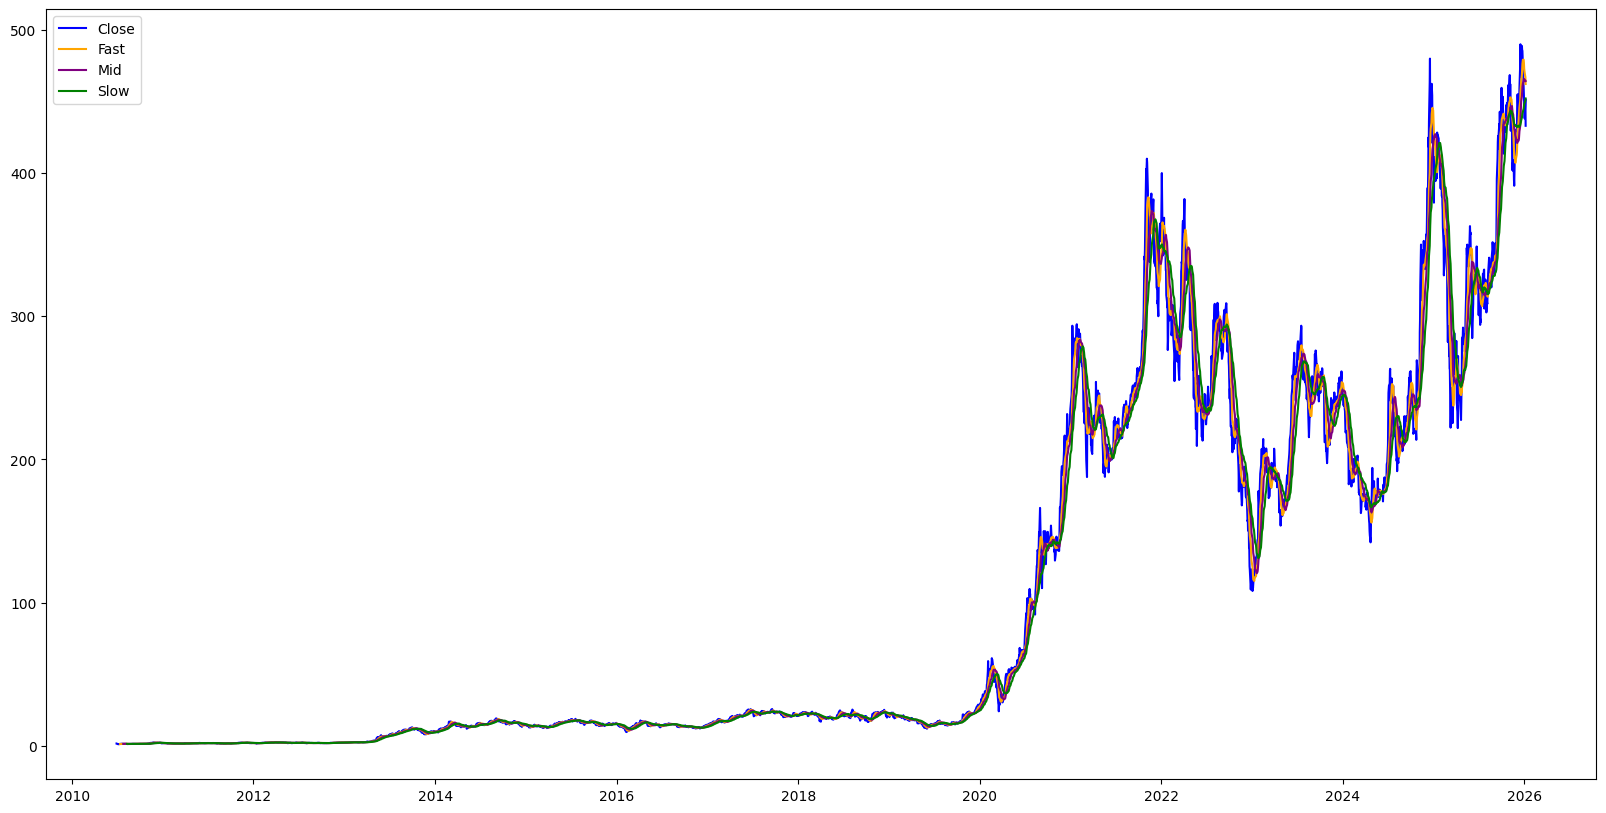

In [156]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(TSLA_data['Close'], color='blue', label='Close')
ax.plot(TSLA_data['FastSMA'], color='orange', label='Fast')
ax.plot(TSLA_data['MidSMA'], color='purple', label='Mid')
ax.plot(TSLA_data['SlowSMA'], color='green', label='Slow')
ax.legend()
plt.show()

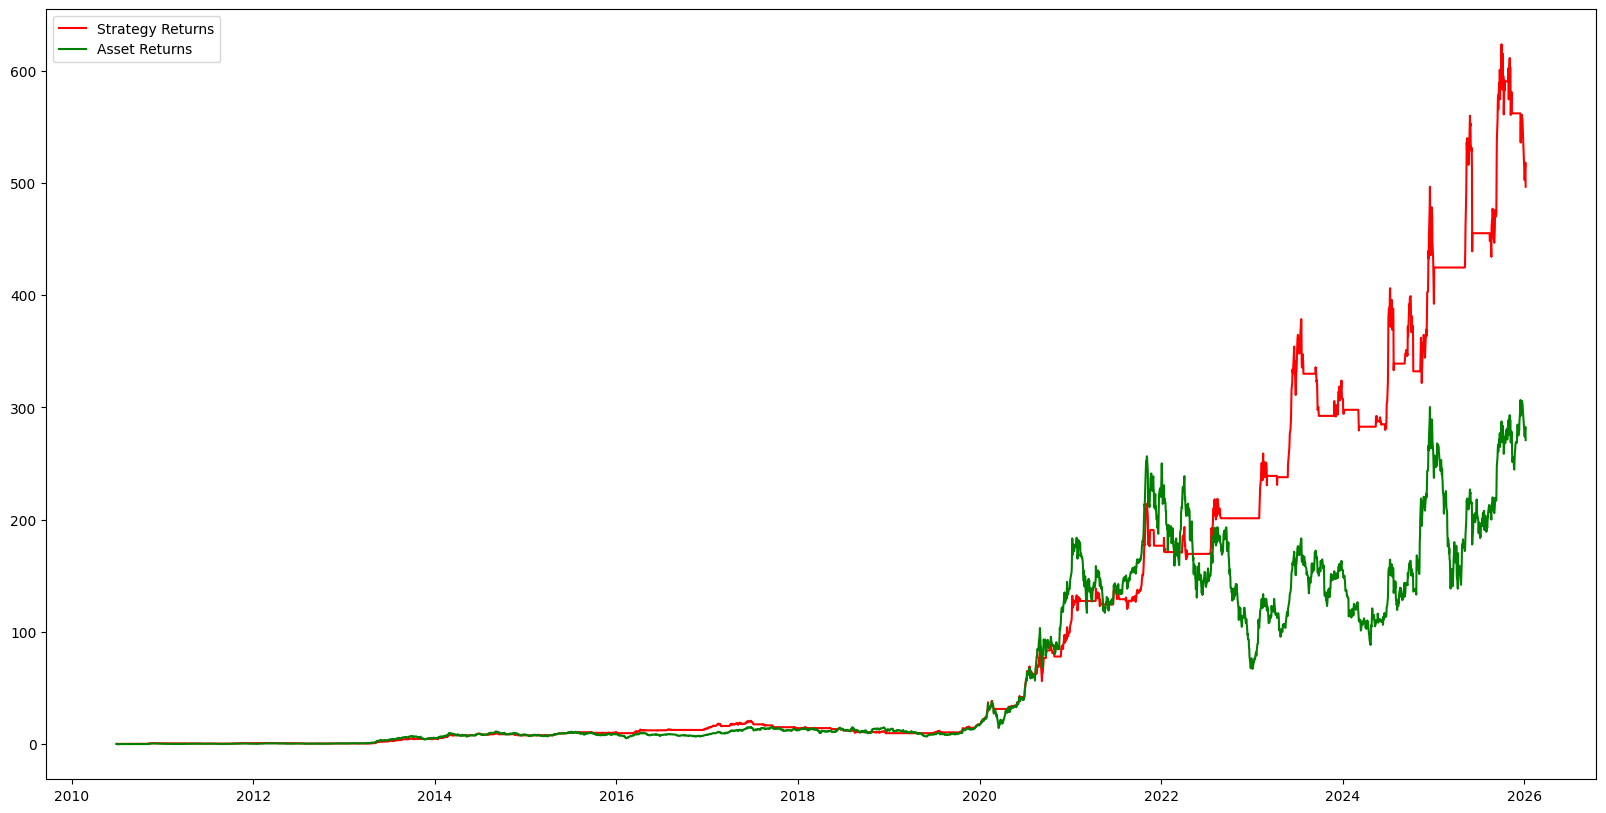

In [157]:

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(TSLA_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(TSLA_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

In [158]:
def run_triple_sma(yf_data, fast, mid, slow):
    data = yf_data.copy()

    close = data['Close']
    returns = close.pct_change().fillna(0)

    fast_sma = close.rolling(fast).mean()
    mid_sma  = close.rolling(mid).mean()
    slow_sma = close.rolling(slow).mean()

    strategy = (
        (fast_sma > mid_sma) &
        (mid_sma > slow_sma)
    ).shift(1).fillna(0).astype(int)

    strat_returns = returns * strategy
    equity = (1 + strat_returns).cumprod()

    total_return = equity.iloc[-1] - 1

    return total_return

In [ ]:
results = []

for fast in range(1, 99):
    for mid in range(fast + 1, 100):
        for slow in range(mid + 1, 101):

            total_return = run_triple_sma(
                yf_tsla_data, fast, mid, slow
            )

            results.append({
                'fast': fast,
                'mid': mid,
                'slow': slow,
                'return': total_return
            })

1


KeyboardInterrupt: 

In [30]:
results_df = pd.DataFrame(results)

results_df['return'] = results_df['return'].apply(
    lambda x: x.iloc[0] if hasattr(x, 'iloc') else x
)

In [38]:
best = results_df.loc[results_df['return'].idxmax()]
best

fast       10.000000
mid        19.000000
slow       30.000000
return    496.700724
Name: 40909, dtype: float64

In [143]:
results_df[
    (results_df['fast'].between(8, 12)) &
    (results_df['mid'].between(17, 22)) &
    (results_df['slow'].between(27, 35))
].sort_values('return', ascending=False).head(10)

,fast,mid,slow,return
40909,10,19,30,496.700724
40908,10,19,29,478.919890
40910,10,19,31,429.995785
40987,10,20,28,412.553311
40989,10,20,30,395.302891
40907,10,19,28,376.783853
40991,10,20,32,366.251145
40988,10,20,29,365.586302
40830,10,18,32,361.574551
40990,10,20,31,353.297289
